# This notebook is built to fit the One-Dimension Diffusion-Advection-Reaction model parameters to experimental data - tensorflow

### imports

In [74]:
import numpy as np
%matplotlib inline
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('seaborn-whitegrid')
from sklearn import linear_model
plt.rcParams["figure.figsize"] = (16,8)
import math
from math import sqrt
from math import e as exp
import seaborn as sns
import statsmodels.api as sm
import random
from scipy import optimize
sns.set(rc={'figure.figsize':(11.7,8.27),"font.size":50,"axes.titlesize":30,"axes.labelsize":30},style="white", context='paper',font_scale=3)
import numba
from numba.experimental import jitclass
import pymc3 as pm
import theano
import theano.tensor as tt
import arviz as az

### model paramenters

In [39]:
B = .10       ### biomass in Kg
D = 1e-3      ### turbid diffusion coeficient
λ =  2e-3   ### degradation rate
u = 1e7/60    ### production rate
V = 0.03      ### river velocity
BV = 1/3      ### boat velocity
T = 10*20     ### sampling time
pf = 5/1000   ### pump flow
H = 50        ### river cross section area

In [40]:
def _solved_river_abv(x):
    return  -(pf/(BV*H)) *(2*B*u*D) /( 4*D*λ - V*sqrt(V**2 + 4*D * λ)+ V**2)* exp**( (V - sqrt(V**2 + 4*D*λ))/ (2*D) * x )

def _solved_river_bl(x):
    return  (pf/(BV*H)) *(2*B*u*D) /(4*D*λ + V*sqrt(V**2 + 4*D * λ)+ V**2) * exp**( (V + sqrt(V**2 + 4*D*λ))/ (2*D) * x )


def _solved_river_abv_complete(x, pf, BV, H, B, u, D, λ, V):
    return  -(pf/(BV*H)) *(2*B*u*D) /( 4*D*λ - V*np.sqrt(V**2 + 4*D * λ)+ V**2)* np.exp( (V - np.sqrt(V**2 + 4*D*λ))/ (2*D) * x )

def _solved_river_abv_complete_tt(x, pf, BV, H, B, u, D, λ, V):
    return  -(pf/(BV*H)) *(2*B*u*D) /( 4*D*λ - V*tt.sqrt(V**2 + 4*D * λ)+ V**2)* tt.exp( (V - tt.sqrt(V**2 + 4*D*λ))/ (2*D) * x )

def _sld_intermediary(Xi, Xf):
    low, high = sorted([Xi, Xf])
    if low >= 0:
        return abs(_solved_river_abv(Xf) - _solved_river_abv(Xi))
    if high <= 0: 
        return abs(_solved_river_bl(Xf) - _solved_river_bl(Xi))

    return _sld_intermediary(low, 0) + _sld_intermediary(0, high)

def sample_eDNA_transect(x0):
    ret = _sld_intermediary(x0, x0 + BV*T) # + random.gauss(0, error)
    if ret< 0: return 0
    else: return ret
    
def sample_eDNA_transect_dowstream_only(x0, T,  pf, BV, H, B, u, D, λ, V):
    return _solved_river_abv_complete(x0+BV*T, pf, BV, H, B, u, D, λ, V) - _solved_river_abv_complete(x0, pf, BV, H, B, u, D, λ, V)

def sample_eDNA_transect_dowstream_only_tt(x0, T,  pf, BV, H, B, u, D, λ, V):
    return _solved_river_abv_complete_tt(x0+BV*T, pf, BV, H, B, u, D, λ, V) - _solved_river_abv_complete_tt(x0, pf, BV, H, B, u, D, λ, V)

In [41]:
sample_eDNA_transect_dowstream_only(np.array([[10,10, 10]]),100 , .005, 1e-5, 1000, np.array([[1,2,3]]), 1e7, 1,2,np.array([[0,0,1]]))

array([[0.00127428, 0.00254857, 0.22688619]])

### get data from multiple sources

In [42]:
#pd.read_csv('Caged fish experiment and hydrodynamic bidimensional modeling highlight the importance to consider 2D dispersion in fluvial environmental DNA studies_ data.txt',\
#            sep = '\t')

In [43]:
#pd.read_csv('Experimental assessment of optimal lotic eDNA sampling and assay multiplexing for a critically endangered fish data.txt',\
#            sep = '\t')


In [92]:
wood = pd.read_csv('wood et all.csv')
wood = wood[(wood['Dist (m)'] != 'Upstream') & (wood['Position'] == 'MidStream')]
wood = wood.dropna(subset=['Dist (m)', 'FishMass (g)','Velocity (m/s)', 'Detect', 'Pg eDNA'])

In [93]:
#wood2 = pd.read_csv('wood et all.csv')
#wood2 = wood2[(wood2['Velocity (m/s)']<= 1)& (wood2['Dist (m)'] != 'Upstream') ]
#wood2 = wood2[(wood2['Dist (m)'].astype(float) <2000)]
#wood2['Dist (m)'] = wood2['Dist (m)'].astype(float)
#wood2
#sns.lmplot(data =wood2, x = 'Dist (m)', y = 'Pg eDNA', hue =  'Position', height = 10, logx=True)

In [94]:
wood['Dist (m)']= wood['Dist (m)'].astype(float) 
wood['FishMass (g)'] = wood['FishMass (g)'].astype(float)
wood['Velocity (m/s)']= wood['Velocity (m/s)'].astype(float)
#wood = wood[(wood.River == 'Waweig River') & (wood['Dist (m)'] >0) & (wood['Velocity (m/s)']>=0)]
wood = wood[ (wood['Dist (m)'] <3000) &  (wood['Dist (m)'] > 0) &  (wood['Velocity (m/s)']>0)]# &  (wood['Pg eDNA']>=0)

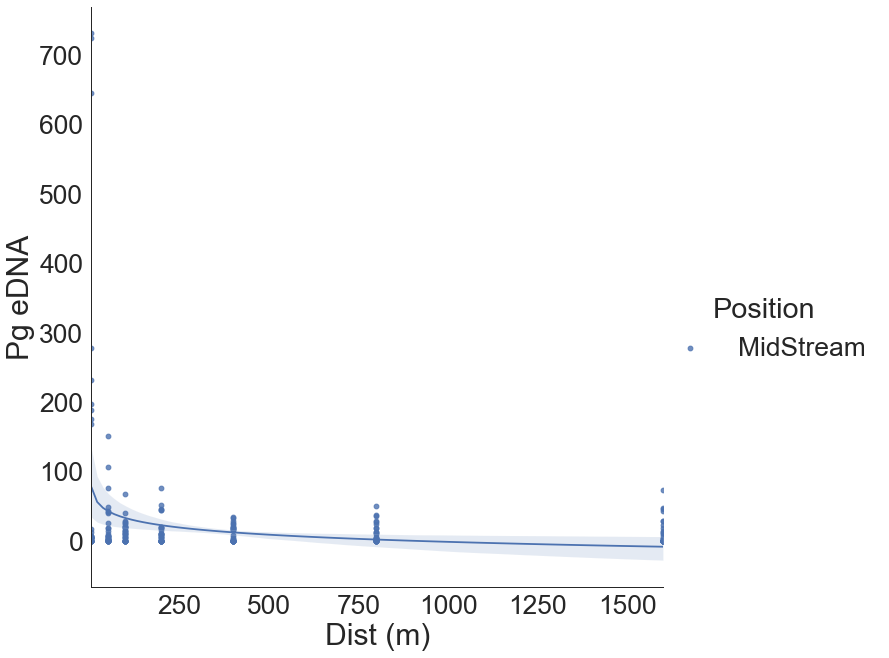

In [95]:
wood['copies eDNA'] = wood['Pg eDNA']#*1000#3705846.15
#wood = wood.query('Detect == 1')
sns.lmplot(data =wood, x = 'Dist (m)', y = 'Pg eDNA', hue =  'Position', height = 10, logx=True)

In [96]:
import theano.tensor as tt
from IPython.core.display import display, HTML

wood_dist = wood[['Dist (m)']].values
wood_mass = wood[['FishMass (g)']].values
wood_vel = wood[['Velocity (m/s)']].values
observed_discrete = wood[['Detect']].values
observed_copies = wood[['copies eDNA']].values
copies_upper_bound = observed_copies.max()*5

In [97]:
from pymc3.distributions import Continuous, Normal

from theano.tensor.random.basic import RandomVariable, normal


class ZeroInflatedNormalRV(RandomVariable):
    name = "zero_inflated_normal"
    ndim_supp = 0
    ndims_params = [0, 0, 0]
    dtype = "int64"
    _print_name = ("ZeroInflatedNormal", "\\operatorname{ZeroInflatedNormal}")

    @classmethod
    def rng_fn(cls, rng, pi,mu ,sigma,  size):
        return rng.normal(mu=mu, sigma=sigma, size=size) * (rng.random(size=size) < pi)
    
    
class ZeroInflatedNormal(Continuous):
    rv_op = ZeroInflatedNormalRV
    
    def __init__(self, mu, sigma, pi, *args, **kwargs):
        super(ZeroInflatedNormal, self).__init__(*args, **kwargs)
        self.mu = mu
        self.sigma = sigma
        self.pi = pi = tt.as_tensor_variable(pi)
        self.Normal = pm.Normal.dist(mu, sigma)

    def logp(self, value):
        return tt.switch(value > 0,
                         tt.log(1 - self.pi) + self.Normal.logp(value),
                         tt.log(self.pi))
    
    







### Continuous eDNA concentration model

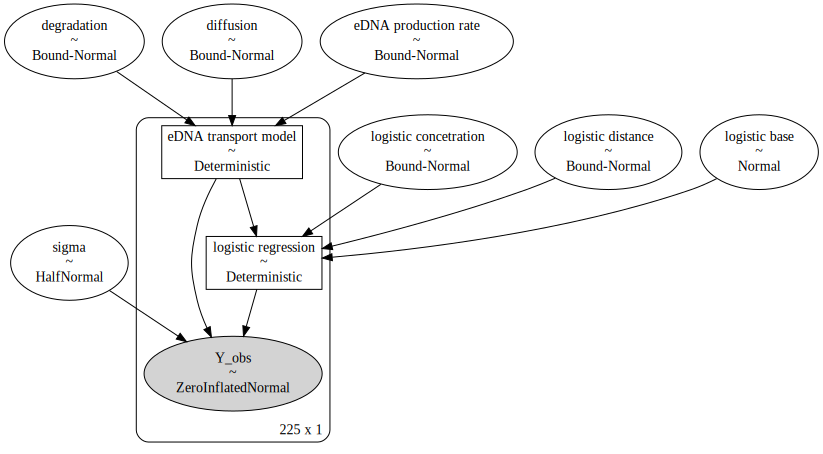

Auto-assigning NUTS sampler...
Initializing NUTS using advi_map...


C:\Users\thiag\anaconda3\envs\mcmc\lib\site-packages\pymc3\distributions\transforms.py:294: RuntimeWarning: divide by zero encountered in log
  return floatX(np.log(x - a) - np.log(b - x))


Convergence achieved at 13100
Interrupted at 13,099 [6%]: Average Loss = 2.9043e+07
Sequential sampling (2 chains in 1 job)
NUTS: [logistic distance, logistic concetration, logistic base, sigma, eDNA production rate, degradation, diffusion]


C:\Users\thiag\anaconda3\envs\mcmc\lib\site-packages\pymc3\distributions\transforms.py:294: RuntimeWarning: divide by zero encountered in log
  return floatX(np.log(x - a) - np.log(b - x))


In [ ]:
with pm.Model() as continouns_model:
    D = pm.Bound(pm.Normal, lower=1e-4, upper = .1)('diffusion',  mu=1e-3, sigma = 10. ) #,shape=(wood_vel.shape[0], 1)
    λ = pm.Bound(pm.Normal, lower=1e-4, upper = .1)('degradation', mu=2e-3,sigma = 10.) #,shape=(wood_vel.shape[0], 1)
    u = pm.Bound(pm.Normal, lower=1e4, upper = 1e8)('eDNA production rate', mu= 2.1*1e5, sigma=10.0) #shape=(wood_vel.shape[0], 1) #pm.Lognormal
    #Vadj = pm.Bound(pm.Normal, lower=-.1, upper = .2)('River_scaler', mu= 0, sigma=1, shape=(wood_vel.shape[0], 1))
    #D = 1e-3
    #u = 2e5
    BV = 1e-5     ### boat velocity
    T = 10*20     ### sampling time
    pf = 5/1000   ### pump flow
    H = 100        ### river cross section area    
    sigma = pm.HalfNormal("sigma", sigma=1)
        
    Yhat = pm.Deterministic('eDNA transport model',sample_eDNA_transect_dowstream_only_tt(wood_dist , T, pf, BV, 10, wood_mass, u, D, λ, wood_vel))
    Yhat = tt.clip(Yhat, 1e-4, copies_upper_bound) #cut large values
    
    a = pm.Normal('logistic base', mu= 0, sigma = 1.)
    b = pm.Bound(pm.Normal, lower=-1, upper = 1)('logistic concetration', mu= 1, sigma=1.0)
    c = pm.Bound(pm.Normal, lower=-1, upper = 1)('logistic distance', mu= 1, sigma=1.0)
    pi = pm.Deterministic('logistic regression', 1/(1+ tt.exp(-(a+tt.log(Yhat)*b + tt.log(wood_dist)*c)))) #
    
    #pi = pm.Deterministic('pi', pm.math.sigmoid(a*Yhat))
    
    # Likelihood (sampling distribution) of observations
    #Y_obs = Normal("Y_obs", mu=Yhat, sigma=sigma,observed=observed_copies)
    Y_obs = ZeroInflatedNormal("Y_obs", mu=Yhat, sigma=sigma,pi= pi, observed=observed_copies)
    #fitted = pm.fit(method="fullrank_advi",n=15000*5, start = pm.find_MAP())
    #trace = fitted.sample(1000 )# 
    display(pm.model_to_graphviz(continouns_model))
    trace = pm.sample(2000, tune=1000, cores=1, return_inferencedata=True, init = 'advi_map')#, init = 'advi_map'
    az.plot_trace(trace, var_names= [ '~eDNA transport model']); #
    #display(az.summary(trace,var_names= [ 'degradation', 'eDNA production rate'] ,round_to=5))
    sns.despine()
    
        

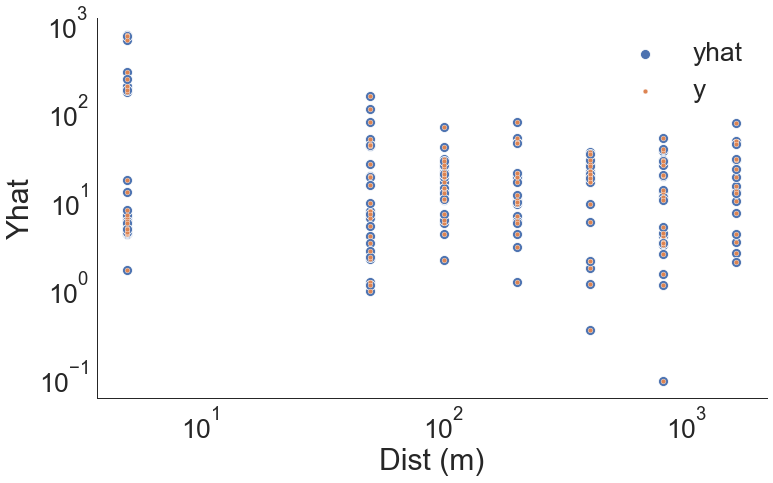

In [183]:
ppc = pm.sample_posterior_predictive(trace, model =continouns_model, var_names=['Y_obs'])
wood['Yhat'] = ppc['Y_obs'].mean(axis= 0)
f, ax = plt.subplots(figsize=(12, 7))
ax.set(xscale="log", yscale="log")# 
sns.scatterplot(data =wood, x = 'Dist (m)', y = 'Yhat', label = 'yhat', s = 100)
sns.scatterplot(data =wood, x = 'Dist (m)', y = 'copies eDNA', label = 'y')
sns.despine()
#plt.ylim([0,100])
#wood

[None, None]

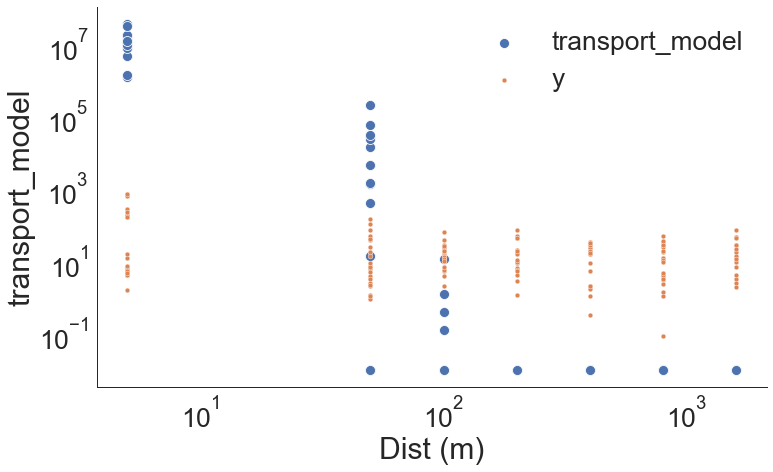

In [184]:
#A[:, np.random.randint(A.shape[0], size=2)] sample from trace
f, ax = plt.subplots(figsize=(12, 7))

ppc = pm.sample_posterior_predictive(trace, model =continouns_model, var_names=['eDNA transport model'])
wood['transport_model'] = np.clip(ppc['eDNA transport model'].mean(axis= 0), 1e-2, copies_upper_bound*10000)
#wood['transport_model'] = ppc['eDNA transport model'].mean(axis= 0)
sns.scatterplot(data =wood, x = 'Dist (m)', y = 'transport_model', label = 'transport_model', s = 100)
sns.scatterplot(data =wood, x = 'Dist (m)', y = 'copies eDNA', label = 'y')
sns.despine()
#plt.ylim([0.01, 10000])
ax.set(xscale="log", yscale = "log")# , yscale = "log"


In [172]:
#wood['estimated diffusion'] = trace['diffusion'].mean(axis= 0)
#wood['estimated degradation'] = trace['degradation'].mean(axis= 0)
#wood['estimated production'] = trace['eDNA production rate'].mean(axis= 0)

#sns.boxenplot(x="River", y='estimated diffusion', data=wood)
#sns.stripplot(x="River", y='estimated diffusion', data=wood, color = 'black')
#sns.despine()
#plt.show()

#sns.boxenplot(x="River", y='estimated degradation', data=wood)
#sns.stripplot(x="River", y='estimated degradation', data=wood, color = 'black')
#sns.despine()
#plt.show()


In [173]:
#sns.pairplot(wood[['estimated diffusion', 'estimated degradation', 'Dist (m)', 'River', 'Velocity (m/s)']], hue="River", height =4 )
#sns.despine()
#plt.show()


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


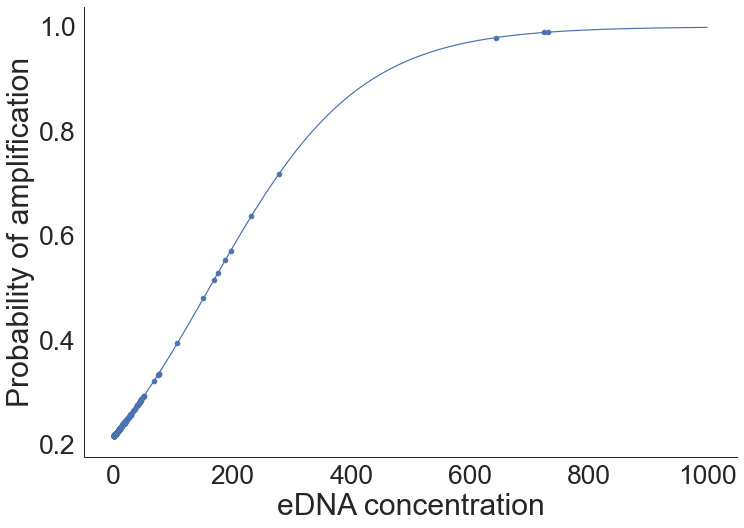

In [175]:
sptmpd = az.summary(trace, round_to=5,  var_names= ['logistic base', 'logistic concetration'])
sptmpd

edna_conc = np.linspace(0, 1000, 1000)
p_amp = 1/(1+np.exp(-(sptmpd.loc['logistic base', 'mean'] + sptmpd.loc['logistic concetration', 'mean']*edna_conc) ))

sns.set(rc={'figure.figsize':(11.7,8.27),"font.size":50,"axes.titlesize":30,"axes.labelsize":30},style="white", context='paper',font_scale=3)
plt.plot(edna_conc, p_amp)
plt.ylabel('Probability of amplification')
plt.xlabel('eDNA concentration')
sns.despine()

p_amp = 1/(1+np.exp(-(sptmpd.loc['logistic base', 'mean'] + sptmpd.loc['logistic concetration', 'mean']*observed_copies )))
sns.set(rc={'figure.figsize':(11.7,8.27),"font.size":50,"axes.titlesize":30,"axes.labelsize":30},style="white", context='paper',font_scale=3)
plt.scatter(observed_copies, p_amp)
plt.ylabel('Probability of amplification')
plt.xlabel('eDNA concentration')
sns.despine()


C:\Users\thiag\anaconda3\envs\mcmc\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


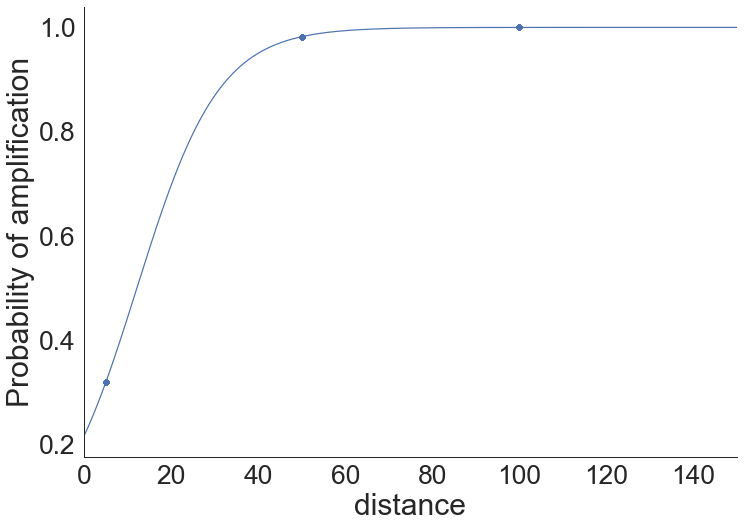

In [176]:
sptmpd = az.summary(trace, round_to=5,  var_names= ['logistic base', 'logistic distance'])
sptmpd

edna_conc = np.linspace(0, 250, 1000)
p_amp = 1/(1+np.exp(-(sptmpd.loc['logistic base', 'mean'] + sptmpd.loc['logistic distance', 'mean']*edna_conc) ))

sns.set(rc={'figure.figsize':(11.7,8.27),"font.size":50,"axes.titlesize":30,"axes.labelsize":30},style="white", context='paper',font_scale=3)
plt.plot(edna_conc, p_amp)
plt.ylabel('Probability of amplification')
plt.xlabel('eDNA concentration')
sns.despine()

p_amp = 1/(1+np.exp(-(sptmpd.loc['logistic base', 'mean'] + sptmpd.loc['logistic distance', 'mean']*wood_dist )))
sns.set(rc={'figure.figsize':(11.7,8.27),"font.size":50,"axes.titlesize":30,"axes.labelsize":30},style="white", context='paper',font_scale=3)
plt.scatter(wood_dist, p_amp)
plt.ylabel('Probability of amplification')
plt.xlabel('distance')
plt.xlim([0,150])
sns.despine()


In [177]:
print('average diffusion: ' + str(az.summary(trace, round_to=5,  var_names= ['diffusion'])['mean'].mean()))
print('average degradation: ' + str(az.summary(trace, round_to=5,  var_names= ['degradation'])['mean'].mean()))
print('average production rate: ' + str(az.summary(trace, round_to=5,  var_names= ['eDNA production rate'])['mean'].mean()))




C:\Users\thiag\anaconda3\envs\mcmc\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
C:\Users\thiag\anaconda3\envs\mcmc\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


average diffusion: 0.00097


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
C:\Users\thiag\anaconda3\envs\mcmc\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


average degradation: 0.09997


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


average production rate: 210027.29909


In [37]:
print(sptmpd.loc['logistic base', 'mean'], sptmpd.loc['logistic beta', 'mean'])

def CtoP2: 
    return 1/(1+np.exp(-(-.83+ .00781*edna_conc) ))

-0.83 0.00781


# using Discrete model

Finished [100%]: Average Loss = 4.9606e+12


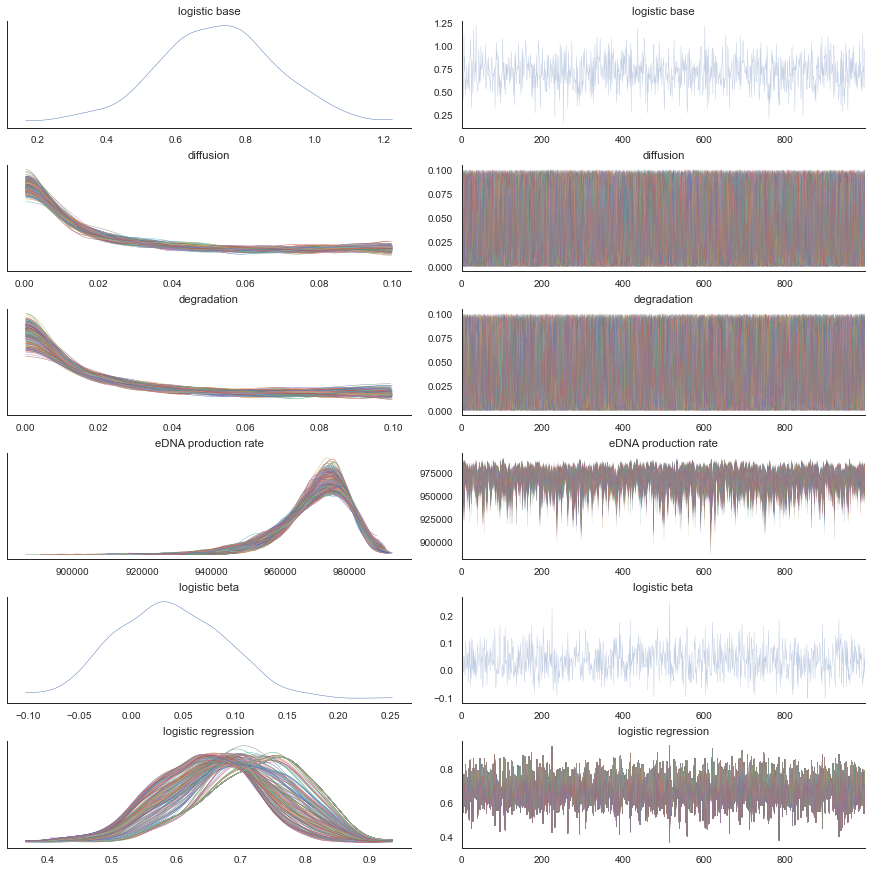

In [1194]:
with pm.Model() as discrete:
    
    D = pm.Bound(pm.Lognormal, lower=1e-4, upper = .1)('diffusion',  mu=1e-3, sigma = 3. ,shape=(wood_vel.shape[0], 1)) #
    λ = pm.Bound(pm.Lognormal, lower=1e-8, upper = .1)('degradation', mu=2e-3,sigma = 3., shape=(wood_vel.shape[0], 1)) #
    u = pm.Bound(pm.Lognormal, lower=1e4, upper = 1e6)('eDNA production rate', mu= 2.1*1e5, sigma=1.0, shape=(wood_vel.shape[0], 1)) #
    a = pm.Normal('logistic base', mu= 0, sigma = 1.)
    #a = 0
    b = pm.Bound(pm.Normal, lower=-1, upper = 1)('logistic beta', mu= 1, sigma=1.0)
    #b = 1e-7
    #copy_number_scaler = pm.Bound(pm.Normal, lower=0.0, upper = 1)('copy number scaler', mu= .1, sigma=1)
    #Vmultiplier = pm.Bound(pm.Normal, lower=-.5, upper = .5)('River_scaler', mu= 0, sigma=1, shape=(wood_vel.shape[0], 1)) #
    #Vest = pm.Bound(pm.Exponential, lower=0.0, upper = 1)('V', lam=.1, shape=(wood_vel.shape[0], 1))
    #D = 1e-3
    #u = 2e5
    BV = 1e-5     ### boat velocity
    T = 10*20     ### sampling time
    pf = 5/1000   ### pump flow
    H = 1        ### river cross section area    
        
    
    q = pm.Deterministic("dispersion model", tt.clip(sample_eDNA_transect_dowstream_only_tt(wood_dist , T, pf, BV, 10, wood_mass, u, D, λ, wood_vel), 1e-2, copies_upper_bound))
    r = pm.Deterministic('log conversion and scaling',tt.log(q)*b)
    s = pm.Deterministic('logistic regression', 1/(1+ tt.exp(-(a+r)))) ## logistic fit


    # Likelihood (sampling distribution) of observations
    yh = pm.Bernoulli("yh", p=s, observed=observed_discrete)
    fitted = pm.fit(method="fullrank_advi",n=12000 ) #"fullrank_advi"
    trace = fitted.sample(1000)
    az.plot_trace(trace, var_names= [ '~dispersion model', '~log conversion and scaling'] ); #
    sns.despine()
    
    
    
        

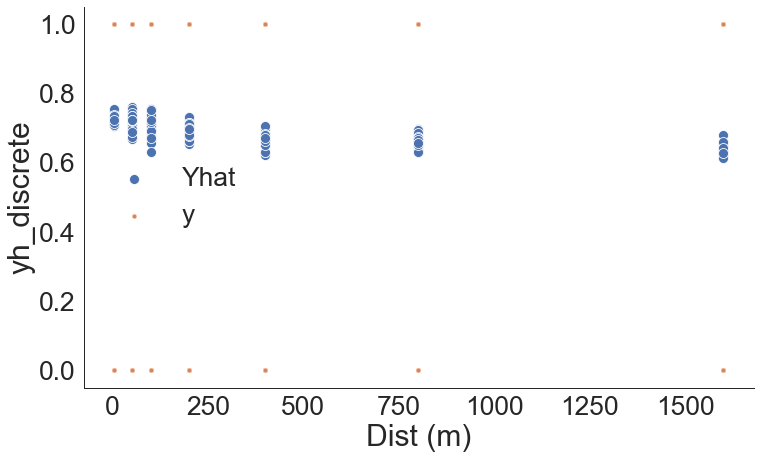

In [1195]:
ppc = pm.sample_posterior_predictive(trace, model =discrete)
wood['yh_discrete'] = ppc['yh'].mean(axis= 0)
f, ax = plt.subplots(figsize=(12, 7))
sns.scatterplot(data =wood, x = 'Dist (m)', y = 'yh_discrete', label = 'Yhat', s = 100)
sns.scatterplot(data =wood, x = 'Dist (m)', y = 'Detect', label = 'y')
sns.despine()
#plt.ylim([0,100])

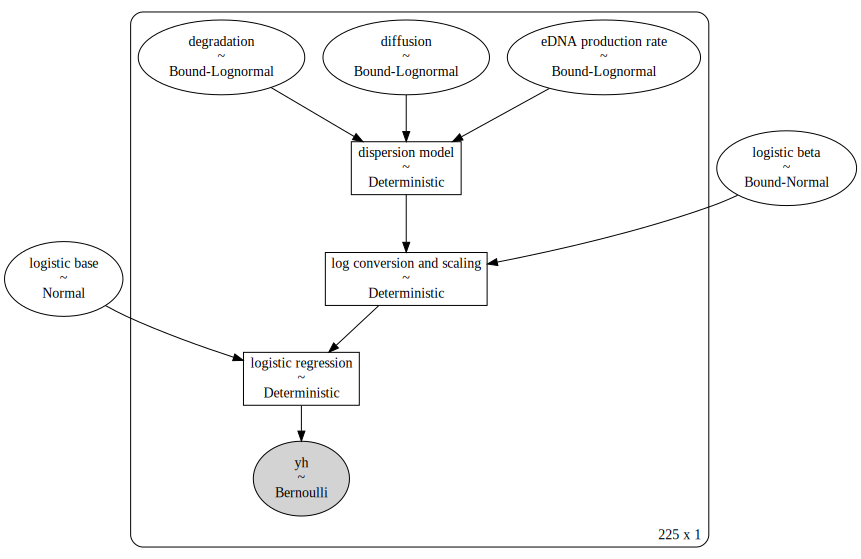

In [1196]:
pm.model_to_graphviz(discrete)

# Using scipy to optimize

In [528]:
from scipy.optimize import minimize
from scipy.stats import trimboth
def to_minimize(list_of_param):
    dif, deg, prod = list_of_param
    data =  trimboth(np.sort(sample_eDNA_transect_dowstream_only(wood_dist , T, pf, BV, 10, wood_mass, prod, dif, deg,  wood_vel) - observed_copies), .1)
    return abs(data).sum()
    
diff, degra, production = minimize(to_minimize, [1e-3, 2e-3, 1e7], bounds = [(1e-3,1), (1e-3, 1), (1e4, 1e7)]).x
wood['yhat_scipy'] = sample_eDNA_transect_dowstream_only(wood_dist , T, pf, 1e-5, 10, wood_mass, production, diff, degra, wood_vel)
f, ax = plt.subplots(figsize=(12, 7))
ax.set(xscale="log", yscale="log") #,
sns.scatterplot(data =wood, x = 'Dist (m)', y = 'Yhat', label = 'yhat')
sns.scatterplot(data =wood, x = 'Dist (m)', y = 'copies eDNA', label = 'y') 
sns.scatterplot(data =wood, x = 'Dist (m)', y = 'yhat_scipy', label = 'yhat_scipy') #plt.ylim([0,100])
sns.despine()

In [614]:
#probfunction = pd.DataFrame([[-2,.333],[-1, .875],[0,1],[1,1], [-10,0], [-3,0], [0, 1]], columns=['initial eDNA', 'probability of amplification'])
#probfunction['copy number'] = probfunction['initial eDNA'].apply(lambda x: 10**x * 3.65*1e6)
#model2 = sm.Logit(probfunction['probability of amplification'].values, probfunction['copy number'].values)
#result2 = model2.fit()
#def CtoP(x): return (result2.predict(x)-.5)/.5


In [616]:
 wood_comp[['Detect']].values

array([[1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]], dtype=int64)

In [ ]:
tt.switch()